<a href="https://colab.research.google.com/github/OsandaDeemantha/Fare-Classification/blob/master/Machine_Learning_Project-6-XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error, confusion_matrix
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Load Data**

In [201]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fare-Classification/Data/train.csv')
df['label'].replace(to_replace=['correct','incorrect'], value=[1,0],inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Explore Data**

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  int

In [203]:
df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1


**Label**

1    0.902131
0    0.097869
Name: label, dtype: float64
Correct:  15495
Incorrect :  1681


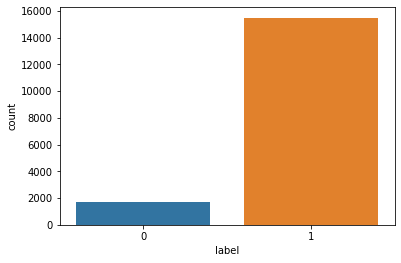

In [204]:
print(df['label'].value_counts(normalize=True))
C, I = df['label'].value_counts()
print('Correct: ',C)
print('Incorrect : ',I)
sns.countplot(df['label'])

**Plot Heat Map**

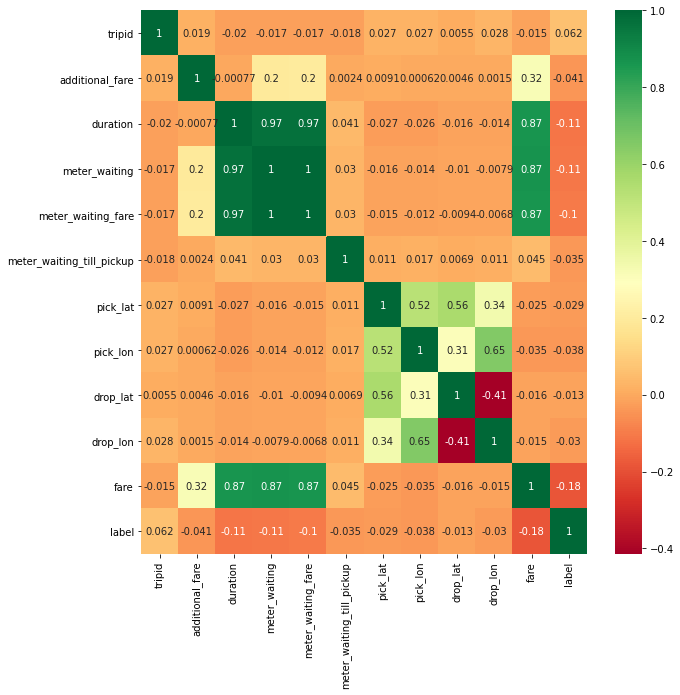

In [205]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# **Feature Engineering**

**Functions**

In [0]:
import datetime
import time
from datetime import timedelta

def extractDataFromDateTimeObj(clock):
  datetimeFormat = '%m/%d/%Y %H:%M'
  dateTimeObj = datetime.datetime.strptime(clock, datetimeFormat)
  dateTimeObj2 = time.strptime(clock, datetimeFormat)
  return [dateTimeObj.year, dateTimeObj.month, dateTimeObj.day, dateTimeObj.hour, dateTimeObj.minute, dateTimeObj.weekday(), dateTimeObj2.tm_yday, dateTimeObj.isocalendar()[1]]

In [0]:
def generateDropTimeData(df):
  df_drop_year = []
  df_drop_month = []
  df_drop_day = []
  df_drop_hour = []
  df_drop_minute = []
  df_drop_weekday = []
  df_drop_dayofyear = []
  df_drop_weekofyear = []

  for time in df['drop_time']:
    data = extractDataFromDateTimeObj(time)
    df_drop_year.append(data[0])
    df_drop_month.append(data[1])
    df_drop_day.append(data[2])
    df_drop_hour.append(data[3])
    df_drop_minute.append(data[4])
    df_drop_weekday.append(data[5])
    df_drop_dayofyear.append(data[6])
    df_drop_weekofyear.append(data[7])

  df['drop_year'] = df_drop_year
  df['drop_month'] = df_drop_month
  df['drop_day'] = df_drop_day
  df['drop_hour'] = df_drop_hour
  df['drop_minute'] = df_drop_minute
  df['drop_weekday'] = df_drop_weekday
  df['drop_dayofyear'] = df_drop_dayofyear
  df['drop_weekofyear'] = df_drop_weekofyear

In [0]:
def generatePickupTimeData(df):
  df_pickup_year = []
  df_pickup_month = []
  df_pickup_day = []
  df_pickup_hour = []
  df_pickup_minute = []
  df_pickup_weekday = []
  df_pickup_dayofyear = []
  df_pickup_weekofyear = []

  for time in df['pickup_time']:
    data = extractDataFromDateTimeObj(time)
    df_pickup_year.append(data[0])
    df_pickup_month.append(data[1])
    df_pickup_day.append(data[2])
    df_pickup_hour.append(data[3])
    df_pickup_minute.append(data[4])
    df_pickup_weekday.append(data[5])
    df_pickup_dayofyear.append(data[6])
    df_pickup_weekofyear.append(data[7])

  df['pickup_year'] = df_pickup_year
  df['pickup_month'] = df_pickup_month
  df['pickup_day'] = df_pickup_day
  df['pickup_hour'] = df_pickup_hour
  df['pickup_minute'] = df_pickup_minute
  df['pickup_weekday'] = df_pickup_weekday
  df['pickup_dayofyear'] = df_pickup_dayofyear
  df['pickup_weekofyear'] = df_pickup_weekofyear

In [0]:
def generatePickupTimestamp(df):
  time = pd.to_datetime(df['pickup_time'])
  df['pickup_timestamp'] = time.values.astype(np.int64) // 10 ** 9

def generateDropTimestamp(df):
  time = pd.to_datetime(df['drop_time'])
  df['drop_timestamp'] = time.values.astype(np.int64) // 10 ** 9

In [0]:
from geopy.distance import geodesic

def calculateDistance(pick_lat,pick_lon, drop_lat, drop_lon):

  coords_1 = (pick_lat, pick_lon)
  coords_2 = (drop_lat, drop_lon)

  if (pick_lon == drop_lon and pick_lat == drop_lat):
    distance = 0.0
    return distance
  else:
    distance = geodesic(coords_1, coords_2).km
    return round(distance, 3)

def calculateDistanceDf(pick_lat_frame,pick_lon_frame, drop_lat_frame, drop_lon_frame):
  distanceList = []

  for i in range(len(drop_lon_frame)):
    pick_lat = pick_lat_frame[i]
    pick_lon = pick_lon_frame[i]
    drop_lat = drop_lat_frame[i]
    drop_lon = drop_lon_frame[i]

    try:
      distance = calculateDistance(pick_lat,pick_lon, drop_lat, drop_lon)
    except:
      print("Error occured! , at", i)

    distanceList.append(distance)
  return distanceList

In [0]:
def calculateFarePerKM(df):
  df_fare_per_km = []

  for i in range (len(df['fare'])):
    if(df['distance'][i]==0.0):
      value = 0.0
    else:
      #value = (df['fare'][i] - df['additional_fare'][i] - df['meter_waiting_fare'][i]) / df['distance'][i]
      value = (df['fare'][i]  - df['meter_waiting_fare'][i]) / df['distance'][i]
      #value = (df['fare'][i]) / df['distance'][i]
    df_fare_per_km.append(round(value, 3))

  df['fare_per_km'] = df_fare_per_km

In [0]:
def calculateFarePerSecond(df):
  df_fare_per_second = []

  for i in range (len(df['fare'])):
    if((df['duration'][i]  - df['meter_waiting'][i])==0.0):
      value = 0.0
    else:
      value = df['fare'][i] / (df['duration'][i]  - df['meter_waiting'][i])
    df_fare_per_second.append(round(value, 3))

  df['fare_per_second'] = df_fare_per_second

In [0]:
def calculateAdditionalFareFactor(df):
  df_additional_fare_factor = []

  for i in range (len(df['fare'])):
    if(df['fare'][i]==0.0):
      value = 0.0
    else:
      value = df['additional_fare'][i] / df['fare'][i]
    df_additional_fare_factor.append(round(value, 3))

  df['additional_fare_factor'] = df_additional_fare_factor

In [0]:
def calculateSpeed(df):
  df_speed = []

  for i in range (len(df['distance'])):
    if((df['duration_timestamp'][i] - df['meter_waiting'][i])==0.0):
      value = 0.0
    else:
      value = df['distance'][i] / (df['duration_timestamp'][i] - df['meter_waiting'][i])
    df_speed.append(round(value, 3))

  df['speed'] = df_speed

**Imputation**

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer

def naImpute(features, column_names):
  imp=SimpleImputer(missing_values=np.NaN)
  idf=pd.DataFrame(imp.fit_transform(features))
  idf.columns=features.columns
  idf.index=features.index

  for column_name in column_names:
    idf[column_name].isna().sum()

  
  return idf

**Pre Process**

In [0]:
def preProcess(df, features):

  generatePickupTimeData(df)
  generateDropTimeData(df)

  generatePickupTimestamp(df)
  generateDropTimestamp(df)

  #calculate trip duration
  df['duration_timestamp'] = df['drop_timestamp'] - df['pickup_timestamp']

  #calculate distance
  df['distance'] = calculateDistanceDf(df['pick_lat'], df['pick_lon'], df['drop_lat'], df['drop_lon'])

  features += ['pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_weekday', 'pickup_dayofyear', 'pickup_weekofyear', 'drop_year', 'drop_month', 'drop_day', 'drop_hour', 'drop_minute', 'drop_weekday', 'drop_dayofyear', 'drop_weekofyear', 'distance','pickup_timestamp','drop_timestamp', 'duration_timestamp']
  df2 = df[features]
  df2 = naImpute(df2,features)

  #calculate waiting fare per unit time
  df2['waiting_fare_per_second'] = df2['meter_waiting_fare'] / df2['meter_waiting']

  calculateFarePerKM(df2)
  calculateAdditionalFareFactor(df2)
  calculateSpeed(df2)
  calculateFarePerSecond(df2)

  features += ['waiting_fare_per_second', 'fare_per_km', 'speed', 'additional_fare_factor', 'fare_per_second']
  Features = df2[features]
  Features = naImpute(Features,features)
  return Features

In [0]:
# shuffle the samples
# df = df.sample(n = len(df), random_state = 42)
# df = df.reset_index(drop = True)
# valid_df = df.sample(frac = 0.2, random_state = 42)
# train_df = df.drop(valid_df.index)
valid_df = df
train_df = df

#train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [218]:
features = ['additional_fare','duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
train_x = preProcess(train_df, features)
train_x.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_weekday,pickup_dayofyear,pickup_weekofyear,drop_year,drop_month,drop_day,drop_hour,drop_minute,drop_weekday,drop_dayofyear,drop_weekofyear,distance,pickup_timestamp,drop_timestamp,duration_timestamp,waiting_fare_per_second,fare_per_km,speed,additional_fare_factor,fare_per_second
0,10.500000,834.000000,56.000000,0.000000,64.000000,270.32,2019.0,11.0,1.0,0.0,20.0,4.0,305.0,44.0,2019.0,11.0,1.0,0.0,34.0,4.0,305.0,44.0,5.072,1.572568e+09,1.572568e+09,840.0,0.00000,53.297,0.006,0.039,0.347
1,10.500000,791.000000,47.000000,0.000000,134.000000,197.85,2019.0,11.0,1.0,0.0,56.0,4.0,305.0,44.0,2019.0,11.0,1.0,1.0,9.0,4.0,305.0,44.0,3.152,1.572570e+09,1.572571e+09,780.0,0.00000,62.770,0.004,0.053,0.266
2,10.500000,1087.000000,80.000000,0.000000,61.000000,301.64,2019.0,11.0,1.0,1.0,8.0,4.0,305.0,44.0,2019.0,11.0,1.0,1.0,26.0,4.0,305.0,44.0,6.302,1.572570e+09,1.572572e+09,1080.0,0.00000,47.864,0.006,0.035,0.300
3,10.500000,598.000000,271.000000,15.663800,68.000000,82.30,2019.0,11.0,1.0,2.0,27.0,4.0,305.0,44.0,2019.0,11.0,1.0,2.0,37.0,4.0,305.0,44.0,0.863,1.572575e+09,1.572576e+09,600.0,0.05780,77.215,0.003,0.128,0.252
4,13.719651,1702.858077,629.074231,32.057666,112.466832,358.39,2019.0,11.0,1.0,3.0,34.0,4.0,305.0,44.0,2019.0,11.0,1.0,3.0,51.0,4.0,305.0,44.0,8.149,1.572579e+09,1.572580e+09,1020.0,0.05096,40.046,0.021,0.038,0.334


In [219]:
train_x.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_weekday,pickup_dayofyear,pickup_weekofyear,drop_year,drop_month,drop_day,drop_hour,drop_minute,drop_weekday,drop_dayofyear,drop_weekofyear,distance,pickup_timestamp,drop_timestamp,duration_timestamp,waiting_fare_per_second,fare_per_km,speed,additional_fare_factor,fare_per_second
count,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,1.717600e+04,1.717600e+04,17176.000000,17176.000000,1.717600e+04,17176.000000,17176.000000,17176.000000
mean,13.719651,1702.858077,629.074231,32.057666,112.466832,312.655466,2019.339136,7.955170,15.903586,13.817536,29.470831,2.909583,227.202143,32.091174,2019.339252,7.954006,15.904751,14.096181,29.412669,2.910922,227.167909,32.089136,4.845560,1.576591e+09,1.576593e+09,1713.929902,0.029533,2.683275e+03,0.003736,0.069487,1.563136
std,98.391294,8072.267835,8015.703284,462.738135,439.447558,602.881578,0.473430,4.999059,8.852767,4.824091,17.288192,1.943430,151.715604,21.867314,0.473469,4.999515,8.852931,4.887015,17.379479,1.944106,151.729763,21.868186,42.954577,2.290002e+06,2.289867e+06,8101.459112,0.027814,3.900632e+04,0.212932,0.066469,15.261617
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.572568e+09,1.572568e+09,0.000000,0.000000,-5.203000e+00,-11.112000,0.000000,-0.398000
25%,10.500000,552.000000,33.000000,0.000000,26.000000,125.960000,2019.000000,1.000000,8.000000,10.000000,15.000000,1.000000,24.000000,4.000000,2019.000000,1.000000,8.000000,11.000000,14.000000,1.000000,24.000000,4.000000,1.482000,1.574690e+09,1.574692e+09,540.000000,0.000000,4.684675e+01,0.003000,0.030000,0.226000
50%,10.500000,1027.000000,128.000000,0.233200,74.000000,213.010000,2019.000000,11.000000,16.000000,14.000000,29.000000,3.000000,319.000000,46.000000,2019.000000,11.000000,16.000000,14.000000,29.000000,3.000000,319.000000,46.000000,3.211000,1.576571e+09,1.576573e+09,1020.000000,0.029533,5.679400e+01,0.004000,0.051000,0.267000
75%,10.500000,1786.000000,367.000000,15.317000,143.000000,364.315000,2020.000000,12.000000,24.000000,18.000000,45.000000,5.000000,343.000000,49.000000,2020.000000,12.000000,24.000000,18.000000,44.000000,5.000000,343.000000,49.000000,6.143250,1.578581e+09,1.578584e+09,1800.000000,0.057873,8.249825e+01,0.005000,0.086000,0.326000
max,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,26945.990000,2020.000000,12.000000,31.000000,23.000000,59.000000,6.000000,365.000000,52.000000,2020.000000,12.000000,31.000000,23.000000,59.000000,6.000000,365.000000,52.000000,5601.634000,1.580515e+09,1.580515e+09,453840.000000,0.061413,3.862116e+06,22.407000,1.426000,961.640000


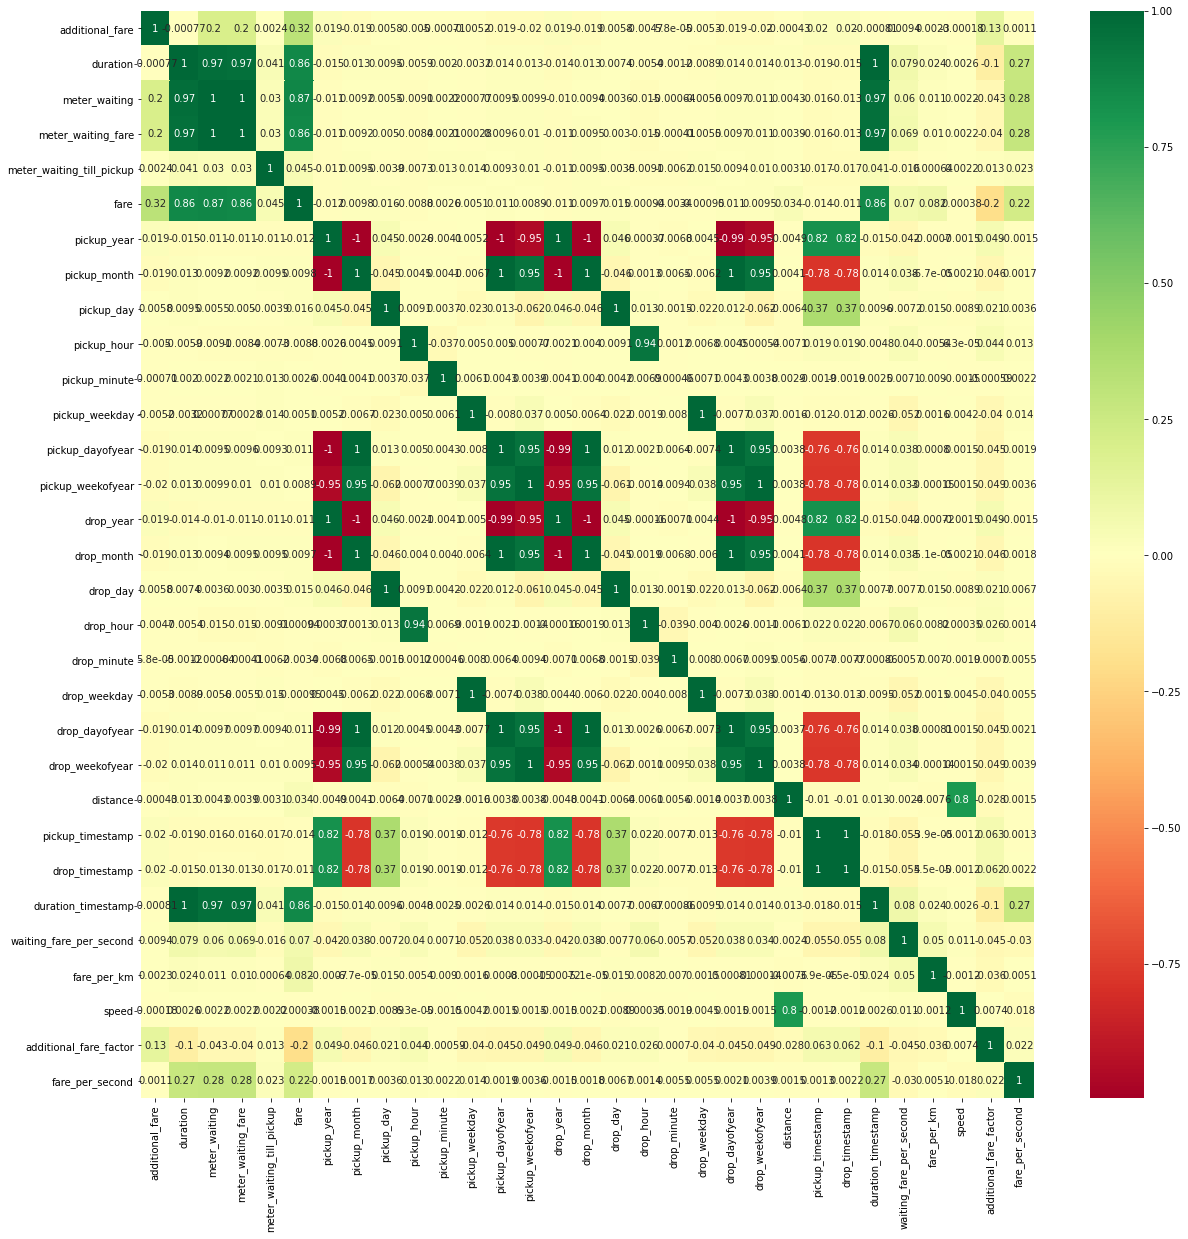

In [220]:
corrmat = train_x.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_x[top_corr_features].corr(),annot=True,cmap="RdYlGn")

2754 2572 2523 2501 2450 2436 1940


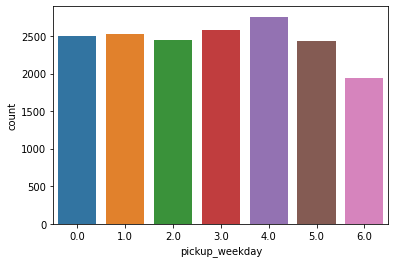

In [221]:
ax = sns.countplot(train_x.pickup_weekday,label="pickup_weekday")
A, B, C, D, E, F, G = train_x.pickup_weekday.value_counts()
print(A,B,C,D,E,F,G)

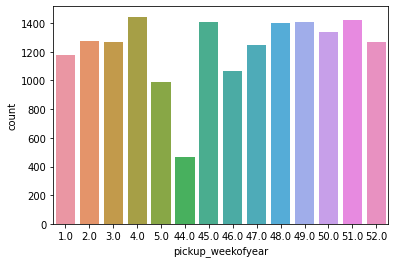

In [222]:
ax = sns.countplot(train_x.pickup_weekofyear,label="pickup_weekofyear")

In [0]:
X = train_x.to_numpy()
y = train_df.label.values

# **XGBoost**

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from xgboost import XGBClassifier

### **Hyperparameter Tunning**

**Random Search**

In [0]:
params = {
 "learning_rate"    : [0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9] ,
 "max_depth"        : [ 3, 4, 5, 6, 7, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ,0.9],
 "subsamples"       : [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
}

classifier = xgboost.XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42, )

#scoring - roc_auc, f1, f1_micro
random_search = RandomizedSearchCV(classifier, param_distributions = params, n_iter=200, scoring='f1_macro', n_jobs=-1, cv=5, verbose=True, )

random_search.fit(X, y)
print(random_search.best_estimator_)
print(random_search.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 34.0min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.4,
              learning_rate=0.003, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, subsamples=0.92, verbosity=1)
{'subsamples': 0.92, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.003, 'gamma': 0.4, 'colsample_bytree': 0.9}


In [0]:
print(random_search.best_estimator_)
print(random_search.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.005, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, subsamples=0.99, verbosity=1)
{'subsamples': 0.99, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.005, 'gamma': 0.2, 'colsample_bytree': 0.7}


**Grid Search**

In [0]:
parameters = {
    'learning_rate'     : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.4, 0.5, 0.6,0.7, 0.8, 0.9],
    'subsamples'        : [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,  0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0],
    'max_depth'         : [1, 2, 3, 4, 5, 6, 8, 10, 12, 15],
    'colsample_bytrees' : [ 0.1, 0.2, 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9, 1],
    'min_child_weight'  : [ 1, 3, 5, 7 ],
    'gamma'             :[ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
}
classifier = xgboost.XGBClassifier(objective= 'binary:logistic', 
                                   nthread=4, 
                                   seed=42, )

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, cv=5,
                   scoring='f1_micro',
                   verbose=True, refit=True)

grid_search.fit(X, y)

Fitting 5 folds for each of 453600 candidates, totalling 2268000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.5s


KeyboardInterrupt: ignored

In [0]:
#trust your CV!
best_parameters, score, _ = max(grid_search.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [0]:
grid_search.best_estimator_

In [0]:
grid_search.best_params_

### **Training & Evaluation**

In [0]:
from sklearn.model_selection import train_test_split
seed = 42 #previously 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed,shuffle=True)

In [225]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# xgb = XGBClassifier(max_depth=9, 
#                     learning_rate=0.05, 
#                     n_estimators=1000, 
#                     verbosity=1, 
#                     silent=None, 
#                     objective='binary:logistic', 
#                     booster='gbtree', 
#                     n_jobs=-1, 
#                     nthread=4, 
#                     gamma=0, 
#                     min_child_weight=1, 
#                     subsample=1, 
#                     random_state=42, )

#Uncomment below code to train model from all data
X_train = X
y_train = y

training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()

acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("Prediction accuracy : %3.3f " % (acc_xgb))
print("Training time : %4.3f seconds" % (xgb_train_time))
print("Prediction time : %6.5f seconds" % (xgb_prediction_time))
print("Mean Absolute Error : %6.5f" % (mean_absolute_error(preds, y_test)))
print("F1 Score : %6.5f" % (f1_score(y_test, preds, average='macro')))
print("Accuracy : %.2f" % (accuracy_score(y_test, preds) * 100))

Prediction accuracy : 97.478 
Training time : 18.752 seconds
Prediction time : 0.19552 seconds
Mean Absolute Error : 0.02522
F1 Score : 0.92036
Accuracy : 97.48


In [182]:
print("Prediction accuracy : %3.3f " % (acc_xgb))
print("Training time : %4.3f seconds" % (xgb_train_time))
print("Prediction time : %6.5f seconds" % (xgb_prediction_time))
print("Mean Absolute Error : %6.5f" % (mean_absolute_error(preds, y_test)))
print("F1 Score : %6.5f" % (f1_score(y_test, preds, average='macro')))
print("Accuracy : %.2f" % (accuracy_score(y_test, preds) * 100))

Prediction accuracy : 95.890 
Training time : 12.663 seconds
Prediction time : 0.18981 seconds
Mean Absolute Error : 0.04110
F1 Score : 0.86951
Accuracy : 95.89


In [226]:
confusion_matrix(y_test, preds)   #117, 36

array([[ 420,  127],
       [  16, 5106]])

# **Prediction**

In [227]:
df_pred = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fare-Classification/Data/test.csv')
features_pred = ['additional_fare','duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
df_pred.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [228]:
pred_x = preProcess(df_pred, features_pred)
X_pred = pred_x.to_numpy()
pred_x.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_weekday,pickup_dayofyear,pickup_weekofyear,drop_year,drop_month,drop_day,drop_hour,drop_minute,drop_weekday,drop_dayofyear,drop_weekofyear,distance,pickup_timestamp,drop_timestamp,duration_timestamp,waiting_fare_per_second,fare_per_km,speed,additional_fare_factor,fare_per_second
0,10.5,924.0,42.0,2.4486,148.0,289.27,2020.0,2.0,1.0,0.0,38.0,5.0,32.0,5.0,2020.0,2.0,1.0,0.0,53.0,5.0,32.0,5.0,6.670,1.580517e+09,1.580518e+09,900.0,0.058300,43.002,0.008,0.036,0.328
1,10.5,4249.0,20.0,0.0000,91.0,1912.70,2020.0,2.0,1.0,1.0,2.0,5.0,32.0,5.0,2020.0,2.0,1.0,2.0,13.0,5.0,32.0,5.0,41.351,1.580519e+09,1.580523e+09,4260.0,0.000000,46.255,0.010,0.005,0.452
2,10.5,1552.0,255.0,2.6588,23.0,394.00,2020.0,2.0,1.0,5.0,2.0,5.0,32.0,5.0,2020.0,2.0,1.0,5.0,28.0,5.0,32.0,5.0,5.920,1.580533e+09,1.580535e+09,1560.0,0.010427,66.105,0.005,0.027,0.304
3,10.5,462.0,16.0,0.0000,198.0,154.32,2020.0,2.0,1.0,5.0,30.0,5.0,32.0,5.0,2020.0,2.0,1.0,5.0,38.0,5.0,32.0,5.0,3.284,1.580535e+09,1.580535e+09,480.0,0.000000,46.991,0.007,0.068,0.346
4,10.5,814.0,392.0,12.3692,69.0,147.47,2020.0,2.0,1.0,7.0,0.0,5.0,32.0,5.0,2020.0,2.0,1.0,7.0,14.0,5.0,32.0,5.0,2.589,1.580540e+09,1.580541e+09,840.0,0.031554,52.183,0.006,0.071,0.349


In [229]:
y_pred = xgb.predict(X_pred)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [230]:
import numpy as np
x = np.array(y_pred)
print("Original array:")
print(x)
unique_elements, counts_elements = np.unique(x, return_counts=True)
print("Frequency of unique values of the array:")
print(np.asarray((unique_elements, counts_elements)))

Original array:
[1 1 1 ... 1 1 1]
Frequency of unique values of the array:
[[   0    1]
 [ 447 8129]]


In [0]:
import csv

with open('/content/drive/My Drive/Colab Notebooks/Fare-Classification/Data/XGB-Tune3.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(['tripid','prediction'])
    for i in range(len(y_pred)):
      submission_writer.writerow([df_pred['tripid'][i],y_pred[i]])